## Data preparation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [69]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from PIL import Image
from zipfile import ZipFile

import os
import pandas as pd

In [9]:
# specify data paths
path = Path('data')
path_img = path/'Agg_AMT_Candidates.zip'
path_labels = path/'labels.txt'

In [39]:
# read labels
images = list()
with open(path_labels, 'r') as f:
    for line in f:
        sline = line.strip().split(' ')
        images.append(sline)

In [40]:
# remove last empty line
images.pop(-1)

['']

In [56]:
# read and save images from ZIP file
with ZipFile(path_img) as archive:
    for entry in archive.infolist()[1:]:
        with archive.open(entry) as file:
            img = Image.open(file)
            if not os.path.exists(path/'images'):
                os.makedirs(path/'images')
            img.save(path/'images'/entry.filename.split('/')[1])

In [85]:
# create data object from dataframe
# labels.csv created form labels.txt

df = pd.read_csv(path/'labels.csv', delimiter=' ', header='infer')
df['name'] = 'images/' + df['name'].astype(str)

data = ImageDataBunch.from_df(path, df, size=224, ds_tfms=get_transforms()).normalize(imagenet_stats)

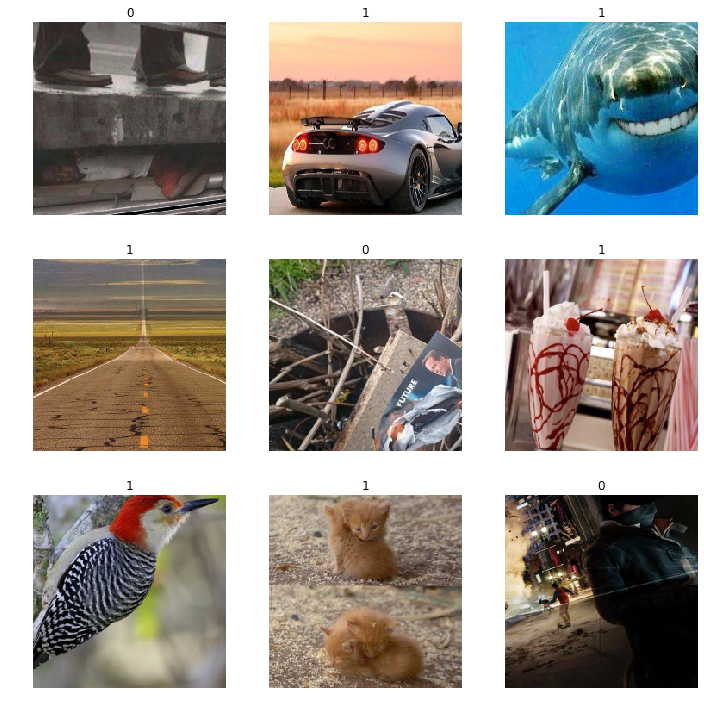

In [125]:
# data examples
data.show_batch(rows=3, figsize=(10,10))

## Resnet34

In [129]:
resnet34 = create_cnn(data, models.resnet34, metrics=error_rate)

In [130]:
# train for 20 epochs
resnet34.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate
1,0.868286,0.623670,0.346591
2,0.748348,0.386114,0.193182
3,0.651733,0.295639,0.153409
4,0.548769,0.275350,0.125000
5,0.475945,0.264181,0.130682
6,0.428222,0.242154,0.096591
7,0.386595,0.268874,0.113636
8,0.342985,0.252611,0.113636
9,0.309703,0.222714,0.119318
10,0.277127,0.226586,0.119318


In [131]:
 resnet34.save('resnet34-1')

In [132]:
resnet34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-05


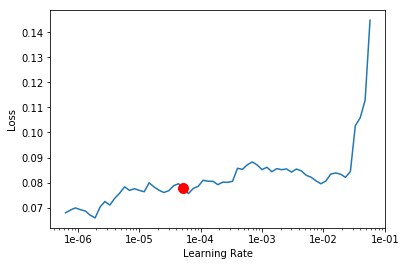

In [133]:
resnet34.recorder.plot()

In [137]:
# try fine-tuning- no improvement
# resnet34.load('resnet34-1')
# resnet34.fit_one_cycle(4, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.093808,0.228647,0.102273
2,0.095003,0.229425,0.102273
3,0.085269,0.230736,0.102273
4,0.088857,0.231619,0.102273


## Resnet50

In [102]:
resnet50 = create_cnn(data, models.resnet50, metrics=error_rate)

In [103]:
resnet50.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate
1,0.745982,0.476229,0.198864
2,0.590924,0.358234,0.153409
3,0.477649,0.377484,0.125000
4,0.402190,0.395986,0.136364
5,0.344788,0.367721,0.130682
6,0.295175,0.259023,0.096591
7,0.251257,0.330607,0.090909
8,0.216545,0.283283,0.085227
9,0.197232,0.302593,0.107955
10,0.177737,0.317333,0.107955


In [106]:
resnet50.save('resnet50-1')

In [104]:
resnet50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05


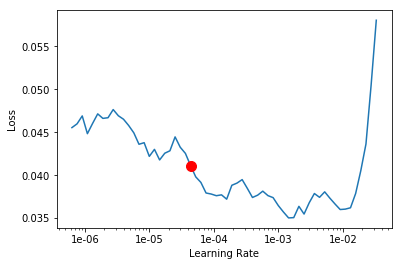

In [105]:
resnet50.recorder.plot()

In [112]:
# fine tuning - no improvement

# resnet50.load('resnet50-1')
# resnet50.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

## Results - Resnet34

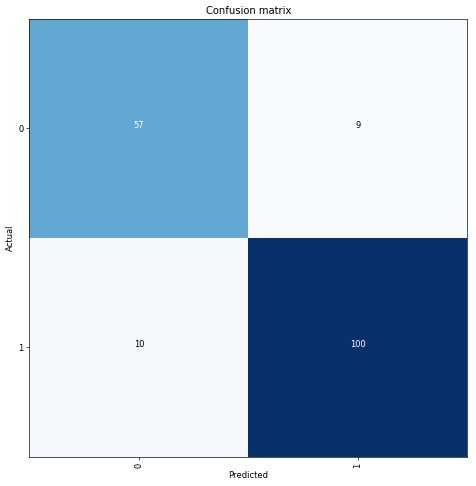

In [139]:
# restore model from before fine-tuning attempt
resnet34.load('resnet34-1')
res34interp = ClassificationInterpretation.from_learner(resnet34)
res34interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

## Results  - Resnet50

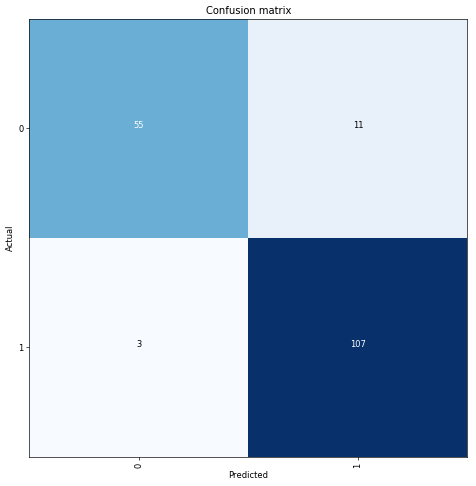

In [140]:
# restore model from before fine-tuning attempt
resnet50.load('resnet50-1')
# plot confusion matrix
res50interp = ClassificationInterpretation.from_learner(resnet50)
res50interp.plot_confusion_matrix(figsize=(8,8), dpi=60)